# CellRank Meets Pseudotime

## Preliminaries

In this tutorial, you will learn how to: 

- compute a pseudotime using {func}`Diffusion pseudotime (DPT)<~scanpy.tl.dpt>` {cite}`haghverdi:16`. 
- use CellRank's {class}`~cellrank.kernels.PseudotimeKernel` to compute a transition matrix based on *any* pseudotime of your liking. 
- visualize the transition matrix in a low-dimensional embedding. 

Along the way, we'll see an example where RNA velocity does not work well {cite}`manno:18, bergen:20, bergen:21`; this motivates us to use the {class}`~cellrank.kernels.PseudotimeKernel`. 

This tutorial notebook can be downloaded using the following [link](https://github.com/theislab/cellrank_notebooks/raw/main/tutorials/cellrank_meets_pseudotime.ipynb).


:::{figure-md} fig-pseudotime-kernel

<img src="_static/img/pseudotime_kernel.jpg" alt="CellRank computes a transition matrix based on any pseudotime. " width="800px">

**The PseudotimeKernel recovers differentiation directionality**: We infuse directionality into a k-NN graph using any pseudotime; edges that point into the pseudotemporal "past" are donw-weighted. This can be understood as an adapted, soft version of the Palantir algorithm {cite}`setty:19`.  
:::

:::{note}
If you want to run this on your own data, you will need:

- a scRNA-seq dataset for which you have computed a pseudotime using a tool like {func}`~scanpy.tl.dpt` {cite}`haghverdi:16`, Palantir {cite}`setty:19` or Slingshot {cite}`street:18`.

:::

:::{note}

If you encounter any bugs in the code, our if you have suggestions for new features, please open an [issue](https://github.com/theislab/cellrank/issues/new/choose). If you have a general question or something you would like to discuss with us, please post on the [scverse discourse](https://discourse.scverse.org/c/ecosytem/cellrank/40). You can also contact us using info@cellrank.org.  

:::

### Import packages & data

In [1]:
import sys

if "google.colab" in sys.modules:
    !pip install -q git+https://github.com/theislab/cellrank

In [2]:
import scvelo as scv
import scanpy as sc
import cellrank as cr
import numpy as np

scv.settings.verbosity = 3
scv.settings.set_figure_params("scvelo")
sc.settings.set_figure_params(frameon=False, dpi=100)
cr.settings.verbosity = 2

Global seed set to 0


In [3]:
import warnings

warnings.simplefilter("ignore", category=UserWarning)

To demonstrate the appproach in this tutorial, we will use a scRNA-seq dataset of human bone marrow {cite}`setty:19`, which can be conveniently acessed through {mod}`~cellrank.datasets.bone_marrow`. 

In [4]:
adata = cr.datasets.bone_marrow()
adata

AnnData object with n_obs × n_vars = 5780 × 27876
    obs: 'clusters', 'palantir_pseudotime', 'palantir_diff_potential'
    var: 'palantir'
    uns: 'clusters_colors', 'palantir_branch_probs_cell_types'
    obsm: 'MAGIC_imputed_data', 'X_tsne', 'palantir_branch_probs'
    layers: 'spliced', 'unspliced'

## Check RNA velocity on this data

Before diving into the actual {class}`~cellrank.kernels.PseudotimeKernel`, let's motivate this choice a bit. We've seen that RNA velocity works well across a range of datasets including the pancres data from the {doc}`cellrank_meets_rna_velocity` tutorial {cite}`bastidas-ponce:19, bergen_20`; so let's check how RNA velocity performs on this dataset. 

We'll check the ratio of spliced to unspliced counts, go through some basic preprocessing, run {mod}`scvelo`, compute a transition matrix using the {class}`~cellrank.kernels.VelocityKernel` and visualize it. To learn more about these steps, please see the {doc}`cellrank_meets_rna_velocity` tutorial. 

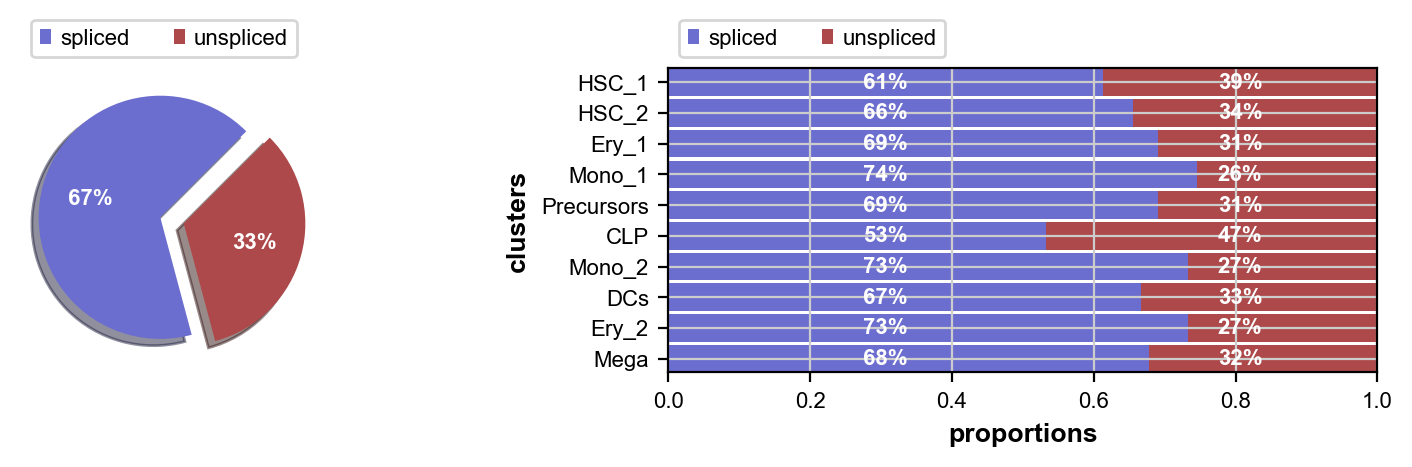

In [5]:
scv.pl.proportions(adata)

This looks fine, the percentage of unspliced reads is about what we would expect for 10x Chromium data {cite}`manno:18`. Next, filter out genes which don't have enough spliced/unspliced counts, normalize and log transform the data and restrict to the top highly variable genes. Further, compute principal components and moments for velocity estimation. 

In [6]:
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000, subset_highly_variable=False)

sc.tl.pca(adata)
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=30, random_state=0)
scv.pp.moments(adata, n_pcs=None, n_neighbors=None)

Filtered out 20068 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing moments based on connectivities
    finished (0:00:02) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


Use the {func}`dynamical model <scvelo.tl.recover_dynamics>` from scVelo to estimate model parameters and compute velocities. On my MacBook using 8 cores, the below cell takes about 2 min to execute. 

In [7]:
scv.tl.recover_dynamics(adata, n_jobs=8)
scv.tl.velocity(adata, mode="dynamical")

recovering dynamics (using 8/8 cores)


  0%|          | 0/588 [00:00<?, ?gene/s]

Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0


    finished (0:01:16) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


Set up the {class}`~cellrank.kernels.VelocityKernel` from the {class}`anndata.AnnData` object containing the scVelo-computed velocities and compute a cell-cell transition matrix. 

In [8]:
vk = cr.kernels.VelocityKernel(adata)
vk.compute_transition_matrix()

Computing transition matrix using `'deterministic'` model


  0%|          | 0/5780 [00:00<?, ?cell/s]

Using `softmax_scale=1.5903`


  0%|          | 0/5780 [00:00<?, ?cell/s]

    Finish (0:00:02)


VelocityKernel[n=5780, model='deterministic', similarity='correlation', softmax_scale=1.59]

Visualize via stream lines an a t-SNE embedding {cite}`van:08`:  

Projecting transition matrix onto `tsne`
Adding `adata.obsm['T_fwd_tsne']`
    Finish (0:00:00)


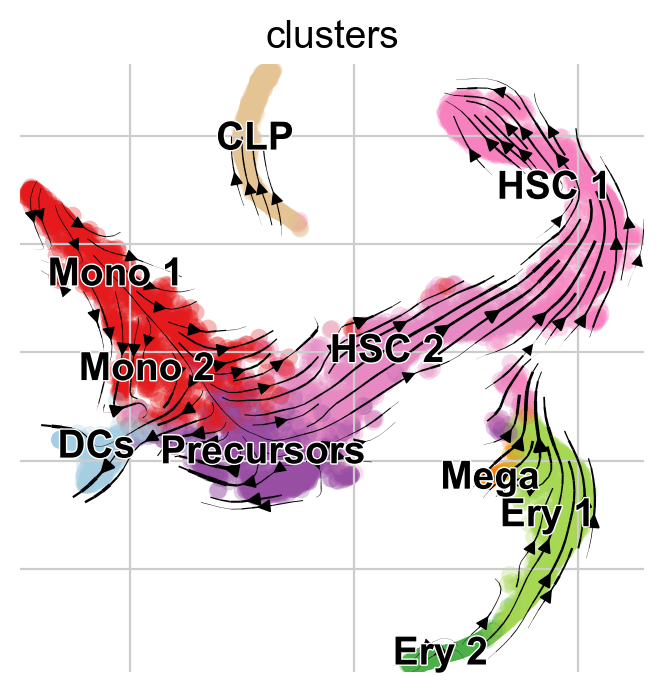

In [9]:
vk.plot_projection(basis='tsne')

:::{note}
Arrows point opposite the known differentiation trajectory in which hematopoietic stems cells (HSCs) differentiate via intermediate states towards Monocyotes (Mono), Dendritic cells (DCs), etc {cite}`setty:19`. That's not just a result of the low-dimensional representation, feel free to use CellRank to compute initial and terminal states on this data (see {doc}`initial_terminal` tutorial) and you'll find them to be inconsistend with biological knowledge as well. 
:::

To explore why this may be the case, let's look into the most influential genes driving the velocity flow here: 

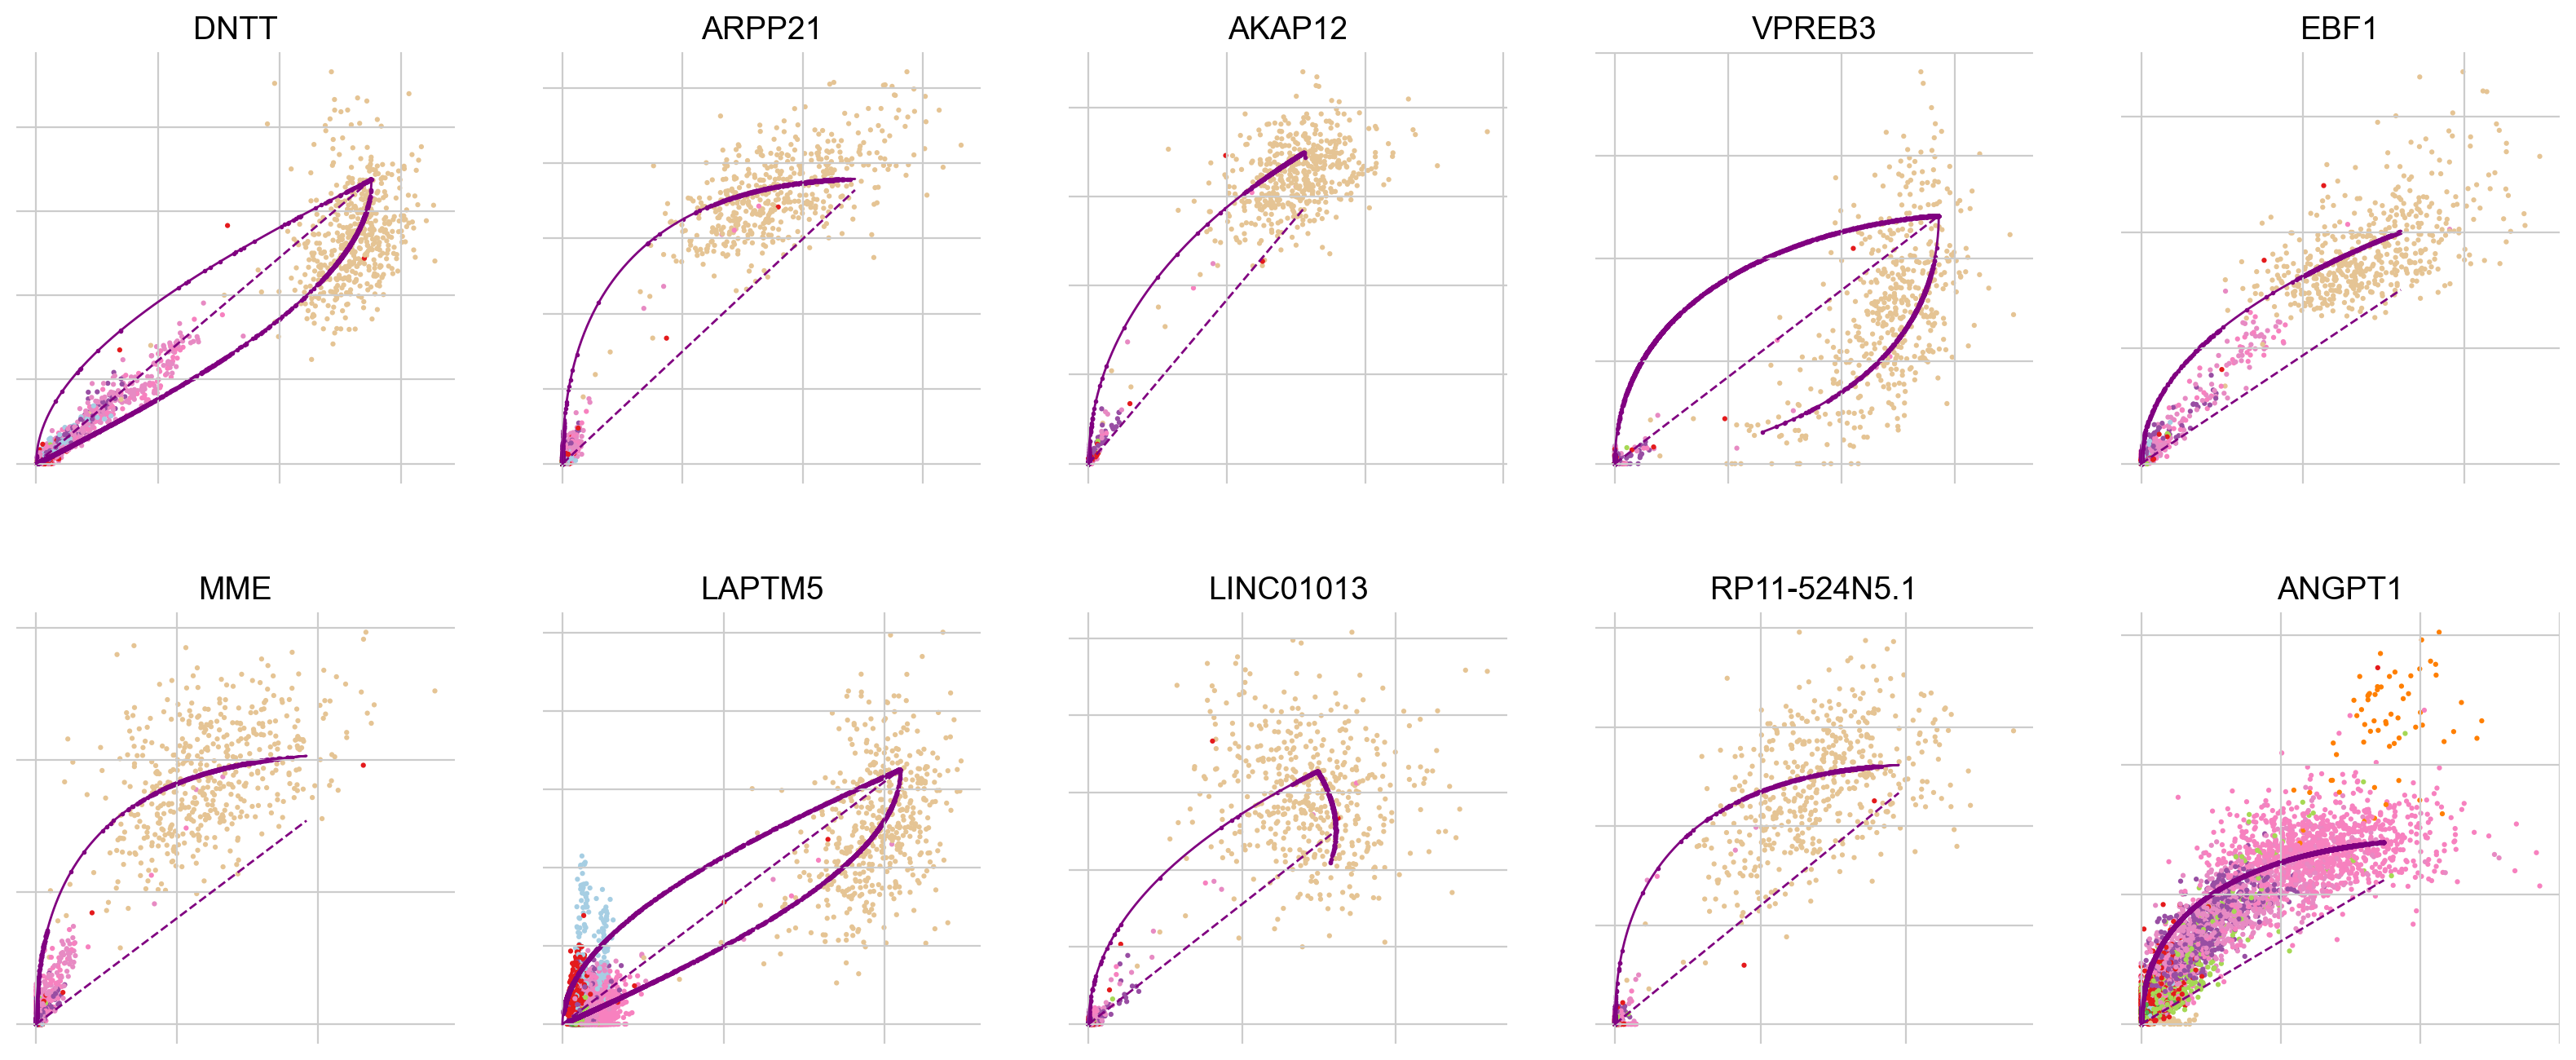

In [10]:
top_genes = adata.var['fit_likelihood'].sort_values(ascending=False).index
scv.pl.scatter(adata, basis=top_genes[:10], ncols=5, frameon=False)

In all of the top likelihood genes, the common lymphoid progenitor cells (CLPs) represent an outlier population. Since the current {mod}`scvelo` model does not account for state-dependent kinetic parmeters, this means the CLPs bias the parameter values for all other cells. We explored what happens if we remove CLPs and re-run the above analysis steps: 

::: {figure-md} fig-no-clps

<img src="_static/img/bm_driver_genes.jpg"   
alt="Without the CLPs, the top-likelihood genes look like they require state and time-dependent rates.">

**Removing CLPs does not resolve the problem:** Even with CLPs removed, projected velocities still point oppposite to what's known. The top-likelihood genes look different now - the CLP outliers have been removed; however, many of these top-influential genes show signs of state and time-dependent kinetic parameters. For example, in *ANK1*, Erythroid cells seem to require their own parameter set and in *RPS16*, the direction is inverted, i.e., an up-regulation is detected as a down-regulation, probably due to transcriptional bursting {cite}`bergen:21, barile:21`. 

:::

There's an easy way in CellRank to overcome these difficulties - use another kernel! In this tutorial, we'll use the {class}`~cellrank.kernels.PseudotimeKernel` because hematopoiesis is a well-studied system where traditional pseutodime methods work well. 

## Use pseudotime to recover directed differentiation

### Choosing the right pseudotime

There are many pseudotime algorithms out there, so how do you choose the right one for your data {cite}`saelens:19`? We'll do a very superficial analysis here and just compare two methods: {func}`diffusion pseudotime (DPT)<scanpy.tl.dpt>` and the [Palantir pseudotime](https://github.com/dpeerlab/Palantir) {cite}`haghverdi:16, setty:19`. 

The Palantir pseudotime has been precomputed for this dataset, check the [original tutorial](https://github.com/dpeerlab/Palantir/blob/master/notebooks/Palantir_sample_notebook.ipynb) and the {func}`scanpy interface <scanpy.external.tl.palantir>` to learn how to do this. To compute DPT on this dataset, we'll start by computing a {func}`diffusion map <scanpy.tl.diffusion_map>` {cite}`coifman:05, haghverdi:15`. 

In [11]:
sc.tl.diffmap(adata)

For DPT, we manually have to suply a root cell (recall, we're not using any RNA velocity here). One (semi-manual) way of doing this is by using extrema of diffusion components:

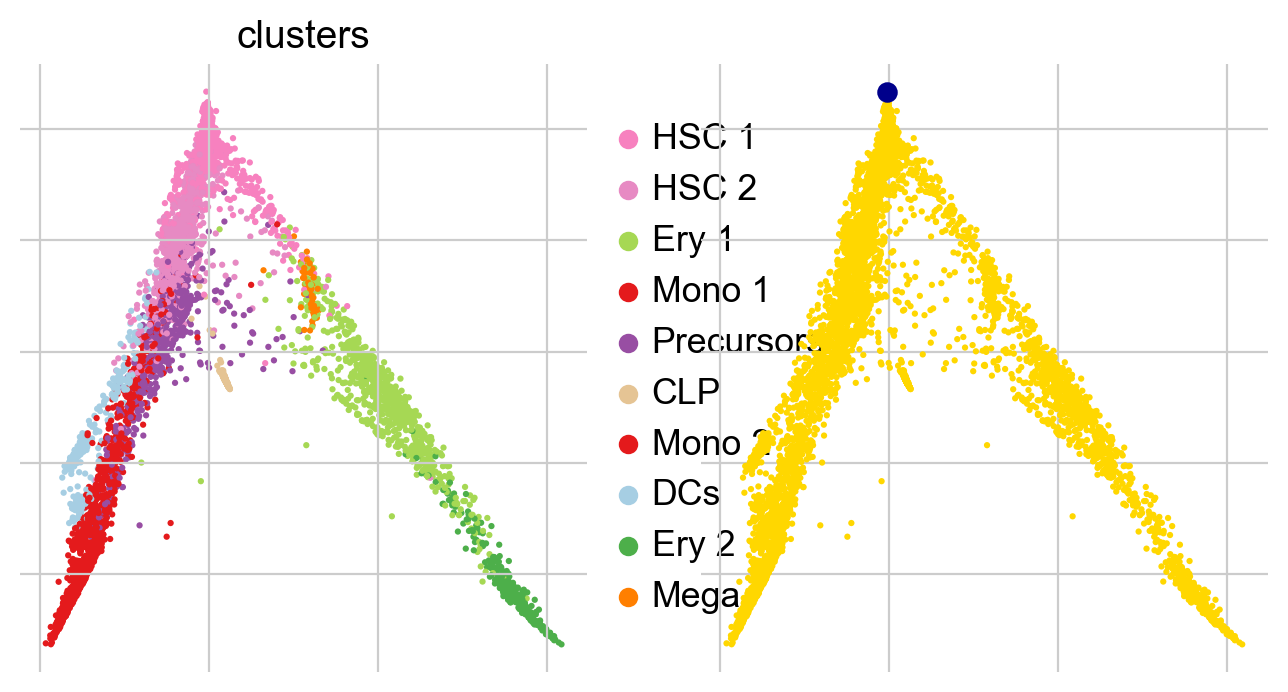

In [12]:
root_ixs = 2394 # has been found using `adata.obsm['X_diffmap'][:, 3].argmax()`
scv.pl.scatter(adata, basis='diffmap', c=['clusters', root_ixs], legend_loc='right', components=['2, 3'])

adata.uns['iroot'] = root_ixs

Once we found a root cell we're happy with (a cell from the HSC cluster), we can compute DPT and compare it with the precomputed Palantir pseudotime: 

/Users/marius/miniforge3/envs/py39_arm_cr/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


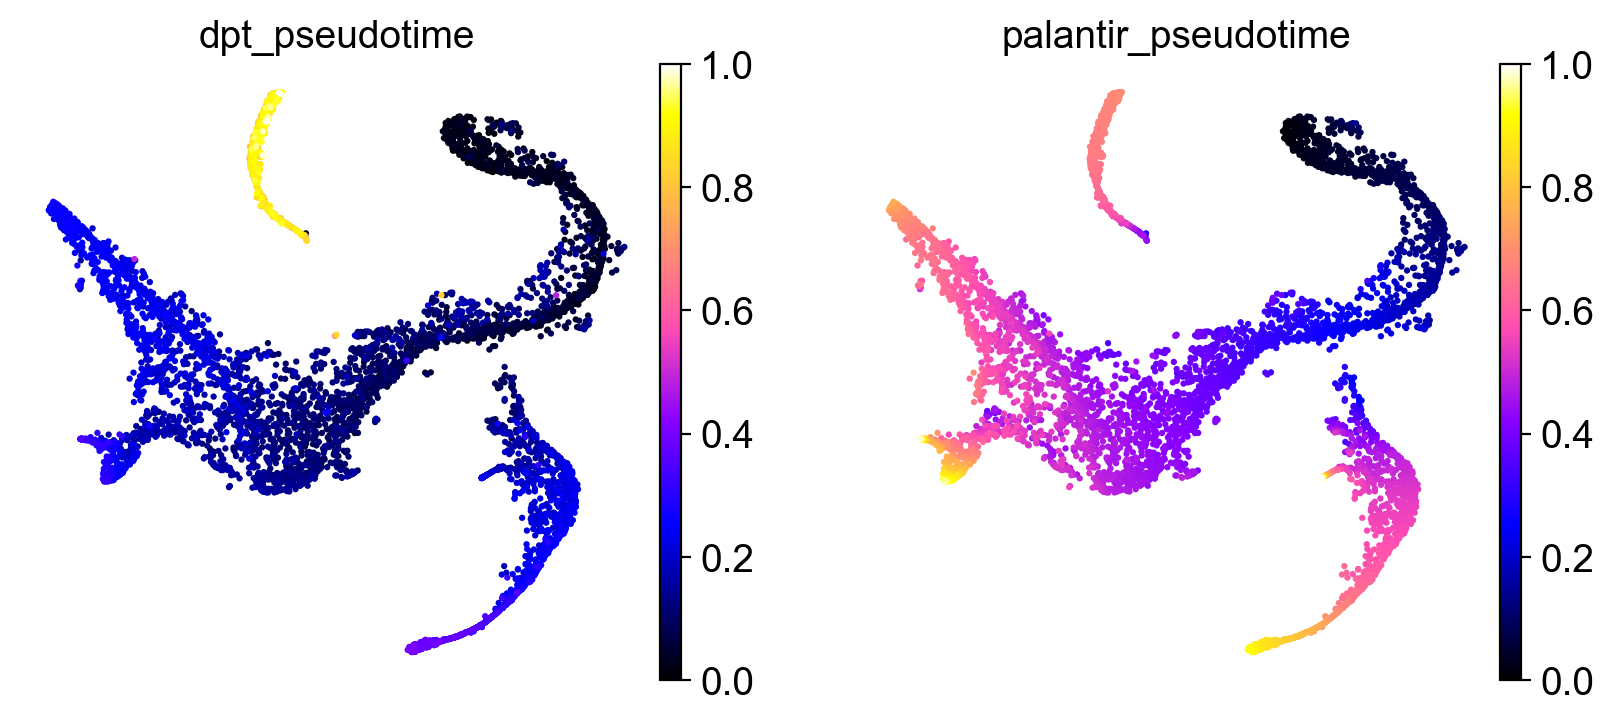

In [13]:
sc.tl.dpt(adata)
sc.pl.embedding(adata, basis='tsne', color=['dpt_pseudotime', 'palantir_pseudotime'], color_map='gnuplot2')

It seems like DPT is a bit biased towards the CLPs; it assigns very high values to that cluster which masks variation among the other states. We can further explore this with violin plots to visualize the distribution of pseudotime values per cluster, restricted to those clusters we expect to belong to a certain trajectory, e.g. the Monocyte or Erythroid trajectories: 

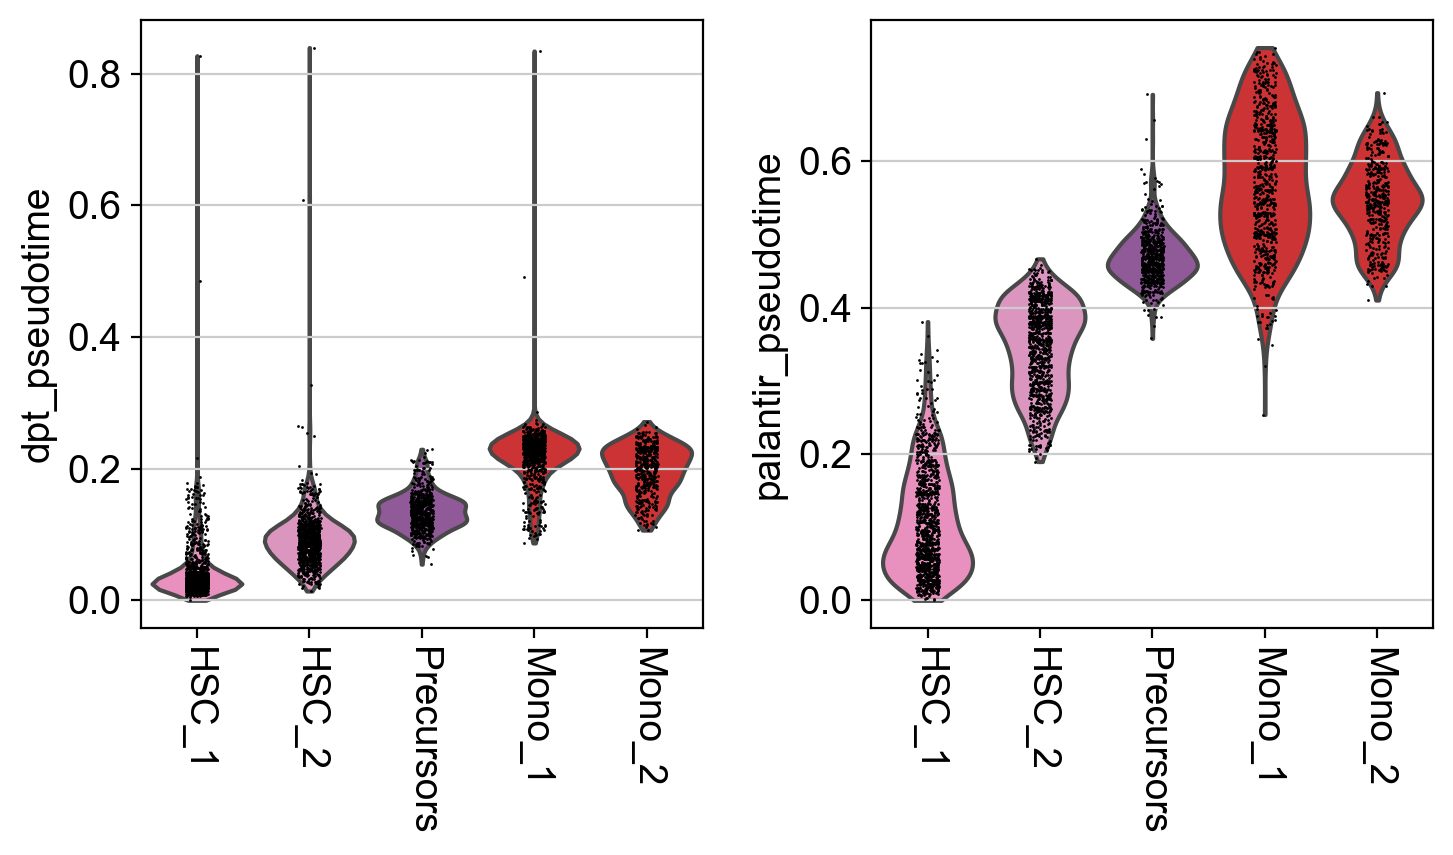

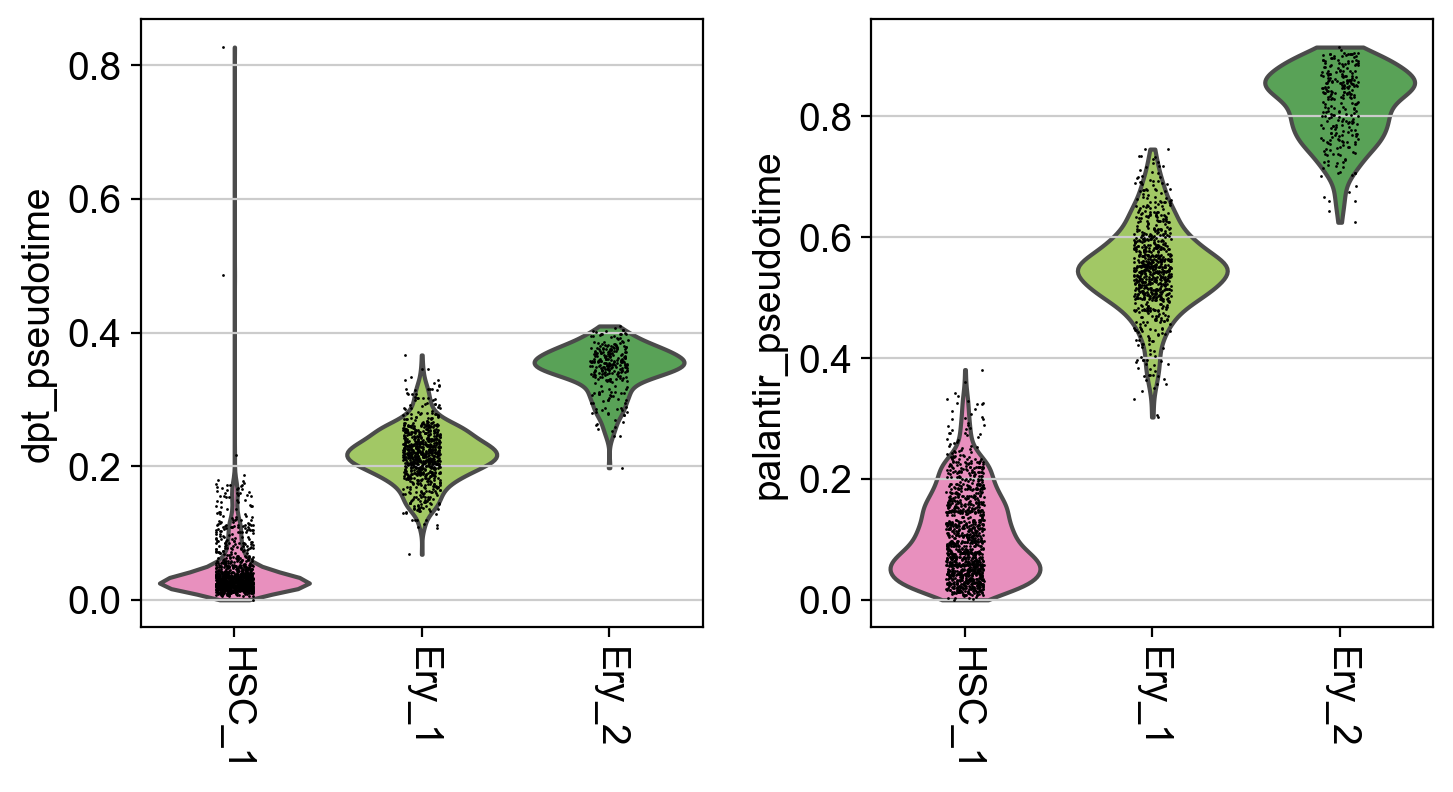

In [14]:
mono_trajectory = ['HSC_1', 'HSC_2', 'Precursors', 'Mono_1', 'Mono_2']
ery_trajectory = ['HSC_1', 'Ery_1', 'Ery_2']

# plot the Monocyte trajectory
mask = np.in1d(adata.obs['clusters'], mono_trajectory)
sc.pl.violin(adata[mask], keys=['dpt_pseudotime', 'palantir_pseudotime'], groupby='clusters', rotation=-90, 
            order=mono_trajectory)

# plot the Erythroid trajectory
mask = np.in1d(adata.obs['clusters'], ery_trajectory)
sc.pl.violin(adata[mask], keys=['dpt_pseudotime', 'palantir_pseudotime'], groupby='clusters', rotation=-90, 
            order=ery_trajectory)

This is a really coarse analysis and only meant to give us a rough idea of which pseudotime to use; generally speaking, they both look good on this dataset. As expected, pseudotimes on average increase as we go towards more mature states. As the Palantir pseudotime appears to be less biased towards CLPs, let's use that for the {class}`~cellrank.kernels.PseudotimeKernel` below. 

### Compute a transition matrix

Let's use the Palantir pseudotime to compute a directed cell-cell transition matrix using the {class}`~cellrank.kernels.PseudotimeKernel`: 

In [15]:
pk = cr.kernels.PseudotimeKernel(adata, time_key='palantir_pseudotime')
pk.compute_transition_matrix()

print(pk)

Computing transition matrix based on pseudotime`


  0%|          | 0/5780 [00:00<?, ?cell/s]

    Finish (0:00:01)
PseudotimeKernel[n=5780]


We can again visualize this transition matrix via streamlines in the t-SNE embedding. 

:::{note}
We do not make use of RNA velocity here, CellRank implements a general way of visualizing k-NN graph-based transition matrices via streamlines in any embedding. Thus, the dynamics in the following plot are purely informed by the pseudotime and the k-NN graph, and not by RNA velocity.  
:::

Projecting transition matrix onto `tsne`
Adding `adata.obsm['T_fwd_tsne']`
    Finish (0:00:00)


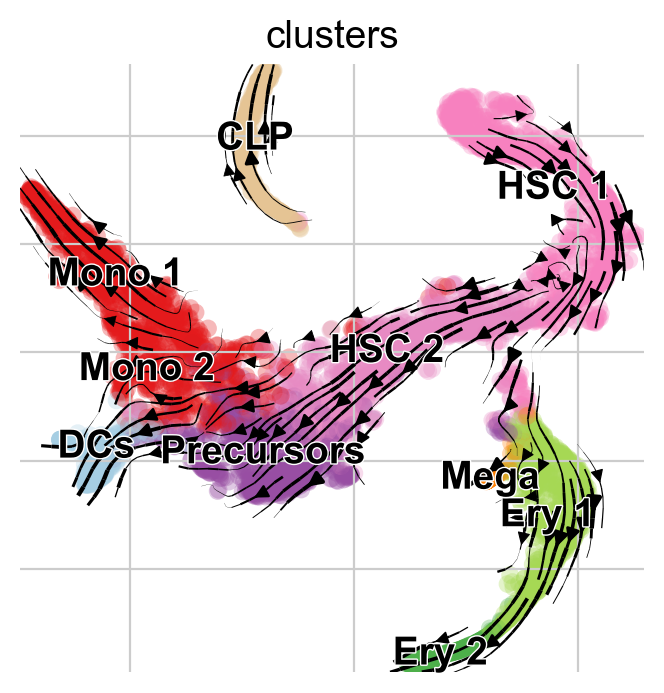

In [16]:
pk.plot_projection(basis='tsne', recompute=True)

This looks much better, the projected dynamics now agree with what is known from biology. 

:::{note}
This is only a low dimensional representation which we shouldn't trust too much; CellRank contains powerful tools to asses the dynamics in high dimensionional data directly via {mod}`estimators <cellrank.estimators>`.   
::: 

## Closing matters

### What's next? 

In this tutorial, you learned how to use CellRank to compute a transition matrix using any precomputed pseudotime and how it can be visualized in low dimensions. The real power of CellRank comes in when you use estimators to analyze the transition matrix directly, rather than projecting it. For the next steps, we recommend to:

- go through the {doc}`initial and terminal states tutorial <initial_terminal>` to learn how to use the transition matrix to automatically identify initial and terminal states. 
- take a look at the {class}`API <cellrank.kernels.PseudotimeKernel>` to learn about parameter values you can use to adapt these computations to your data. 
- explore the vast amount of pseudotime methods to find the one that works best for your data {cite}`saelens:19`. 

### Package versions

In [17]:
cr.logging.print_versions()

cellrank==1.5.1+gedbc651e scanpy==1.9.3 anndata==0.8.0 numpy==1.24.2 numba==0.57.0rc1 scipy==1.10.1 pandas==1.5.3 pygpcca==1.0.4 scikit-learn==1.1.3 statsmodels==0.13.5 python-igraph==0.10.4 scvelo==0.3.0 pygam==0.8.0 matplotlib==3.7.0 seaborn==0.12.2
